In [1]:
import dns
import numpy as np
from pathlib import Path
from scipy import optimize as opt
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams.update(
    {
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "axes.labelsize": 13,
        "axes.titlesize": 14,
        "legend.fontsize": 10,
        "figure.autolayout": True,
        "figure.dpi": 100,
        "figure.figsize": [10, 5],
    }
)

In [2]:
Ry = True
statesdir = Path("/home/gokhan/projects/dnsbox/re149")
savedir = statesdir

In [3]:
state_, header_ = dns.readState(statesdir / "state.000000")
forcing, nx, ny, nz, Lx, Lz, Re, tilt_angle, dt, itime, time = header_
ny_half = ny // 2

In [4]:
if Ry and ny_half % 2 != 0:
    exit("Ry but ny_half is not even.")

In [5]:
def find_shift(projection):
    shift = (np.arctan2(projection.imag, projection.real) / (2 * np.pi)) % 1
    return shift

def find_dphases(projections, times):
    shifts = find_shift(projections)
    phases = np.unwrap(shifts * 2 * np.pi)
    dts = times[1:] - times[:-1]
    dphases = (phases[1:] - phases[:-1]) / dts
    return dphases

def constraint_unit_template(coeffs):
    return np.sqrt(np.sum(coeffs**2))

def maximize_projection_amplitudes(coeffs, projs):
    res = np.einsum("ij,j",projs,coeffs,dtype=np.complex128)
    abs_res = np.abs(res)
    return -np.sqrt(np.average(abs_res**2))

In [6]:
def opt_maximize_projection_amplitudes(projections,str_projections,times,verbose=1,maxiter=1000):
    
    tag = f"{str_projections}"
    print(tag)
    
    nstates, ncoeffs = projections.shape
    u, s, uh = np.linalg.svd(np.einsum("ki,kj",np.conj(projections),projections).real,hermitian=True)
    x0 = u[:,0] / np.sqrt(np.sum(u[:,0]*u[:,0]))
    
    constraints = opt.NonlinearConstraint(constraint_unit_template,1,1)
    
    # run the optimization
    opts = opt.minimize(maximize_projection_amplitudes,x0,args=(projections,),method="trust-constr",
                        constraints=constraints,
                        options={"verbose": verbose, "maxiter": maxiter})
    
    coeffs = opts.x
    
    # save coefficients
    np.savetxt(savedir / f"coeffs_{tag}.gp", coeffs)
    
    # save template
    template = np.zeros((nx, ny_half, nz, 3), dtype=np.complex128)
    if Ry:
        if str_projections == "x":
            template[1,1:,0,0] = coeffs[:ny_half-1] / 4
            template[-1,1:,0,0] = coeffs[:ny_half-1] / 4
            
            template[1,1:,0,1] = -1j*coeffs[ny_half-1:2*ny_half-2] / 4
            template[-1,1:,0,1] = -1j*coeffs[ny_half-1:2*ny_half-2] / 4
            
            template[1,:,0,2] = coeffs[2*ny_half-2:] / 4
            template[-1,:,0,2] = coeffs[2*ny_half-2:] / 4

        elif str_projections == "z":
            template[0,:,1,0] = coeffs[:ny_half] / 4
            template[0,:,-1,0] = coeffs[:ny_half] / 4

            template[0,1:,1,1] = -1j*coeffs[ny_half:2*ny_half-1] / 4
            template[0,1:,-1,1] = -1j*coeffs[ny_half:2*ny_half-1] / 4

            template[0,1:,1,2] = coeffs[2*ny_half-1:] / 4
            template[0,1:,-1,2] = coeffs[2*ny_half-1:]/ 4
    else:
        exit("Not yet implemented.")
    
            
    dns.writeState_nocompact(template,forcing=forcing,Lx=Lx,Lz=Lz,Re=Re,tilt_angle=tilt_angle,dt=dt,
                   outFile = savedir / f"u_{str_projections}p.000000")

    projections_opt = np.einsum("ij,j",projections,coeffs,dtype=np.complex128)
    dphases = find_dphases(projections_opt, times)
    
    if str_projections == "x":
        L = Lx / 2
    elif str_projections == "z":
        L = Lz / 2

    fig, ax = plt.subplots()
    ax.plot(times, np.abs(projections_opt))
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$|p_{str_projections}|$")
    ax.set_yscale("log")
    ax.set_xlim(left=times[0], right=times[-1])
    fig.savefig(savedir / f"p{tag}.png", bbox_inches="tight")

    # Plot phase derivatives
    fig, ax = plt.subplots()
    ax.plot(times[:-1], dphases*L/(2*np.pi))
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$\\dot{{\\phi_{str_projections}}} L_{str_projections} / (2\\pi)$")
    ax.set_xlim(left=times[0], right=times[-2])
    fig.savefig(savedir / f"dphase_{tag}.png", bbox_inches="tight")
    
    plt.show()
    
    return times[:-1], dphases 

In [7]:
cut_percent=20

data_x = np.loadtxt(statesdir / "slice_projections_x.gp")
data_x=data_x[cut_percent*len(data_x)//100:-cut_percent*len(data_x)//100]

data_z = np.loadtxt(statesdir / "slice_projections_z.gp")
data_z=data_z[cut_percent*len(data_z)//100:-cut_percent*len(data_z)//100]

projections_x_runtime_rview = data_x[:,2:]
projections_z_runtime_rview = data_z[:,2:]

projections_x_runtime = projections_x_runtime_rview[:,::2] + 1j*projections_x_runtime_rview[:,1:][:,::2]
projections_z_runtime = projections_z_runtime_rview[:,::2] + 1j*projections_z_runtime_rview[:,1:][:,::2]

times_x = data_x[:,1]
times_z = data_z[:,1]

x
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 23, CG iterations: 0, optimality: 3.79e-10, constraint violation: 1.11e-16, execution time: 0.00066 s.


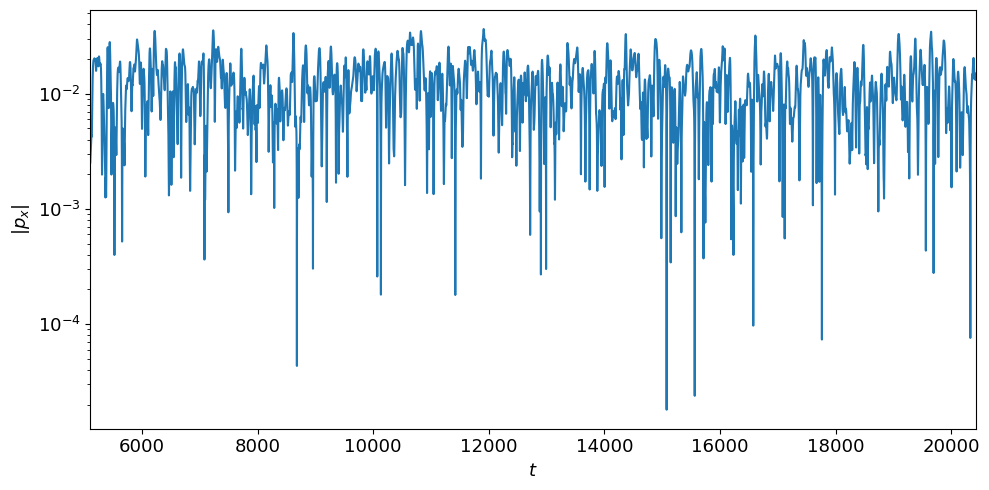

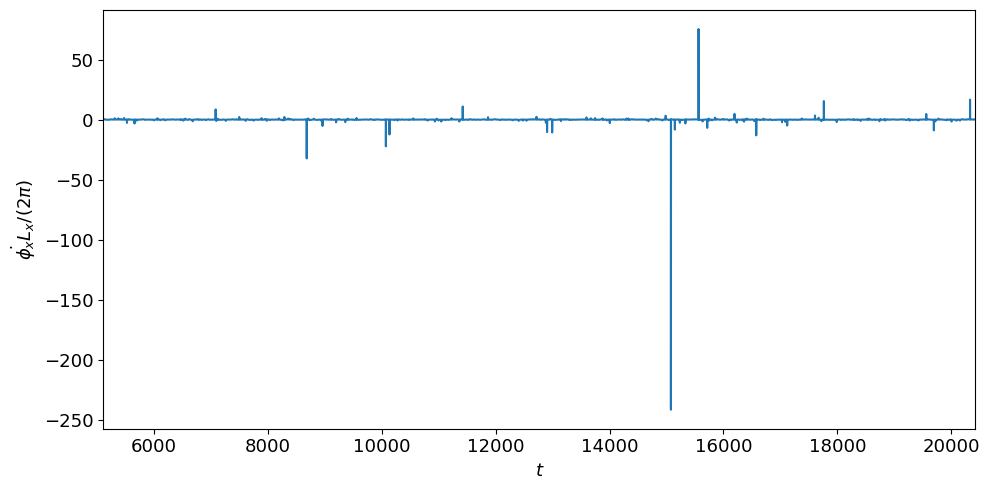

z
`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 23, CG iterations: 0, optimality: 1.86e-09, constraint violation: 0.00e+00, execution time: 0.00049 s.


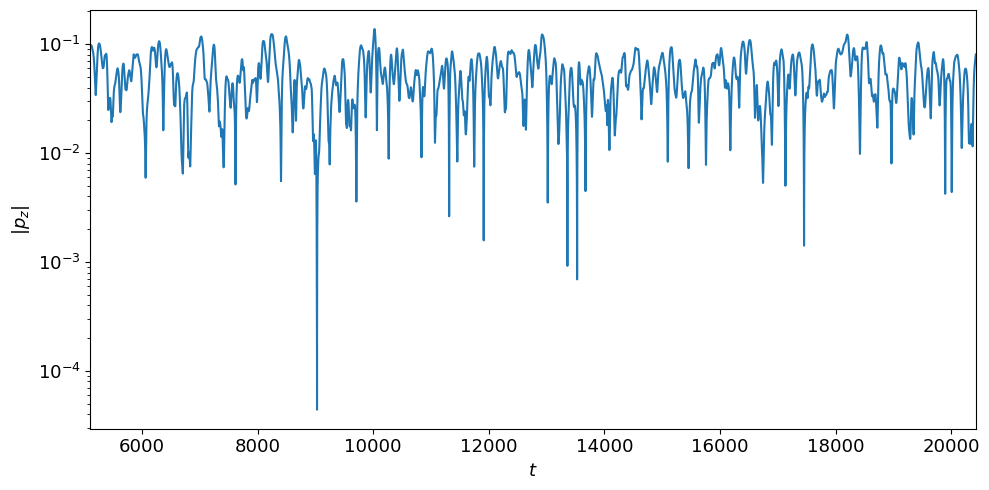

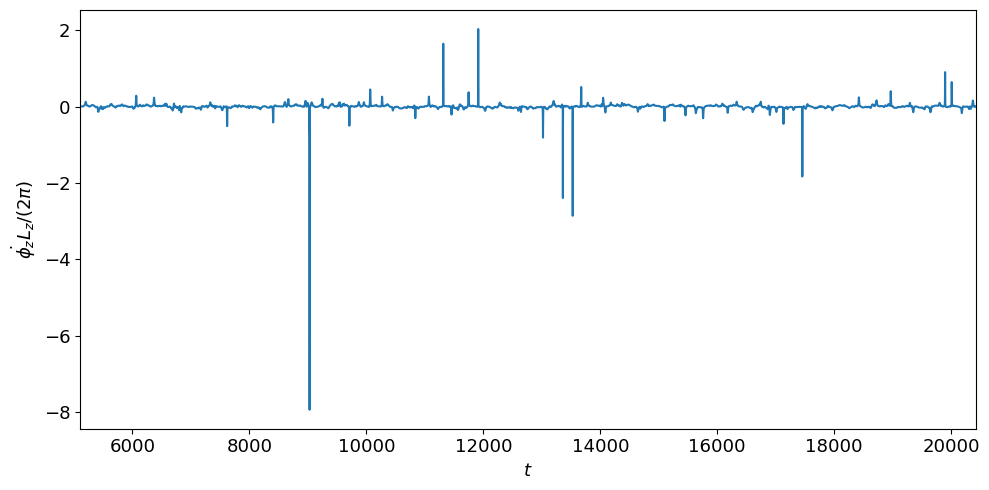

In [8]:
times, dphix_maxproj = opt_maximize_projection_amplitudes(np.conjugate(projections_x_runtime),"x", times_x)
times, dphiz_maxproj = opt_maximize_projection_amplitudes(np.conjugate(projections_z_runtime),"z", times_z)